# **Which Neighborhood in Pittsburgh is best to find parking in?**

### **By CodeCrafters Collective (Quinn Boquist, Matthew Crigler, and Brandon Kowalski)**

*group name generated by ChatGPT* :)

![ParkingMeter](meterPic.jpg)

## **Introduction**

Everyone has tried to find parking in the city before. Depending on where you are, it might be pretty difficult! Look no further, as we have come up with a way to determine the best neighborhood to park in through analyzing three submetrics: metered spot density, **MATT'S METRIC**, and **BRANDON'S METRIC**. By combining the results of these tests we can determine which neighborhood will be the easiest and cheapest place to find parking. We considered also including popularity as a metric, but then the best neighborhood would vary from time to time, and we are looking for an overall best choice assuming average conditions.

### **Our Combined Metric: Parkability.**
 - Metered Spot Density (metered spots per mile of road)
 - Number of parking lot spots versus cost of parking
 - Total amount of Transactions in a neighborhood

### **Datasets used on this project:**

Parking Meter Locations (Quinn): https://data.wprdc.org/dataset/pittsburgh-parking-meters-and-payment-points/resource/db139ccd-6753-48ad-b3ff-118fe2223d55

- **Used for locations of all metered spots.**


Transportation Data (Quinn): https://data.wprdc.org/dataset/pgh/resource/5d61b60b-bd25-4c33-8420-e31a9135ec6e

- **Used for total street mileage.**



Zone and Lot Attributes (Matt): https://data.wprdc.org/dataset/zone-and-lot-attributes

- **Used for space counts and rate in each zone.**

- used Quinn's parking meter location data to translate Pittsburgh Parking Authority zones to neighborhoods


Meter Transactions (Brandon): https://data.wprdc.org/dataset/parking-transactions/resource/f58a2f59-b2e8-4067-a7d9-bbedb7e119b0

- Used for total amount of parking meter transactions

## **Metric 1: Metered Spot Density**
### Quinn

This metric provides useful information because the higher the spot density, the faster you can search through spots for an empty one. Additionally, just the number of metered spots in a neighborhood shows the capacity it has for parking.

I first started by importing some important stuff like pandas and this code snippet for turning coordinates into neighborhoods.

In [2]:
import pandas as pd
import geopandas
from shapely.geometry import Point
import matplotlib.pyplot as plt

#CODE SNIPPET
NEIGHBORHOODS = geopandas.read_file("https://data.wprdc.org/dataset/e672f13d-71c4-4a66-8f38-710e75ed80a4/resource/c5a93a8e-03d7-4eb3-91a8-c6b7db0fa261/download/pittsburghpaneighborhoods-.zip")
ZIPS = geopandas.read_file("https://data.wprdc.org/dataset/1a5135de-cabe-4e23-b5e4-b2b8dd733817/resource/ec228c0e-6b1e-4f44-a335-df05546d52ea/download/alcogisallegheny-county-zip-code-boundaries.zip")
def geo_to_neighborhood(latitude, longitude):
    pt = Point(longitude, latitude)
    for _idx, neighborhood in NEIGHBORHOODS.iterrows():
        if neighborhood["geometry"].contains(pt):
            return neighborhood["hood"]
    return None

Then, I used that function to calculate the total number of metered parking spots for all neighborhoods.

In [2]:
rawcontents=pd.read_csv("ParkingSpotLocations.csv")
meters={}
count=0
avg=0.0
nan=0
num=0
for lat in rawcontents.latitude:                          #counts the parking meters in each neighborhood and adds to a dictionary
    if count%10000==0:                                    #takes a few minutes to run so I added a progress indicator
        print("Progress:", count//10000, "/7")
    lon=rawcontents.longitude[count]
    if type(lat)==type(lon)==type(avg):                   #some coordinates in file were not a number
        hood=geo_to_neighborhood(lat,lon)
        if hood==None:
            num+=1
        else:
            if hood in meters.keys():
                meters[hood]=meters[hood]+1
            else:
                meters[hood]=1
    else:
        nan+=1
    count+=1
print("Non-number coordinates:",nan)
print("Coordinates that aren't in a neighborhood:",num)
meters

<ipython-input-2-e58cdd6f6892>:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  rawcontents=pd.read_csv("ParkingSpotLocations.csv")


Progress: 0 /7
Progress: 1 /7
Progress: 2 /7
Progress: 3 /7
Progress: 4 /7
Progress: 5 /7
Progress: 6 /7
Progress: 7 /7
Non-number coordinates: 7550
Coordinates that aren't in a neighborhood: 6797


{'Squirrel Hill South': 3486,
 'Allegheny Center': 2361,
 'North Oakland': 6641,
 'Crawford-Roberts': 565,
 'Central Oakland': 1776,
 'Central Business District': 7172,
 'South Side Flats': 5570,
 'Allegheny West': 1448,
 'Strip District': 3114,
 'Shadyside': 2975,
 'East Allegheny': 734,
 'West Oakland': 888,
 'Central Lawrenceville': 1186,
 'East Liberty': 3583,
 'Mount Washington': 936,
 'Brookline': 1184,
 'Lower Lawrenceville': 935,
 'Carrick': 639,
 'Terrace Village': 717,
 'Knoxville': 322,
 'Greenfield': 198,
 'Bloomfield': 4106,
 'Bluff': 2041,
 'Point Breeze': 244,
 'North Shore': 2151,
 'Squirrel Hill North': 1610,
 'Garfield': 249,
 'Allentown': 269,
 'South Oakland': 417,
 'Duquesne Heights': 216,
 'Upper Hill': 148,
 'Brighton Heights': 50,
 'West End': 387,
 'Beechview': 510,
 'Upper Lawrenceville': 76,
 'Central Northside': 297,
 'Perry North': 172,
 'Friendship': 98,
 'Homewood South': 71}

Now that we know how many parking spots are in each neighborhood, we need to relate this to how much road there is in each neighborhood. I got this information from the transportation dataset.

In [25]:
rawcontents=pd.read_csv("transportation.csv")                   #gets total miles of roads for each neighborhood
roads={}
count=0
for hood in rawcontents.Neighborhood:
    if hood in meters.keys():
        roads[hood]=rawcontents['Total Street Miles'][count]
    count+=1

myKeys = list(meters.keys())                                     #sort by neighborhood name for combining data
myKeys.sort()
sorted_meters = {i: meters[i] for i in myKeys}
myKeys = list(roads.keys())
myKeys.sort()
sorted_roads = {i: roads[i] for i in myKeys}
roadsVals=sorted_roads.values()
frame=pd.DataFrame.from_dict(sorted_meters, orient='index', dtype=None, columns={"Parking Spots"})  #create dataframe
frame['Street Miles']=roadsVals
frame

,Parking Spots,Street Miles
Allegheny Center,2361,4.14
Allegheny West,1448,4.87
Allentown,269,12.33
Beechview,510,30.75
Bloomfield,4106,31.74
Bluff,2041,16.48
Brighton Heights,50,29.52
Brookline,1184,56.88
Carrick,639,45.98
Central Business District,7172,30.84


Final step is to calculate the density of parking spots to scale each neighborhood fairly.

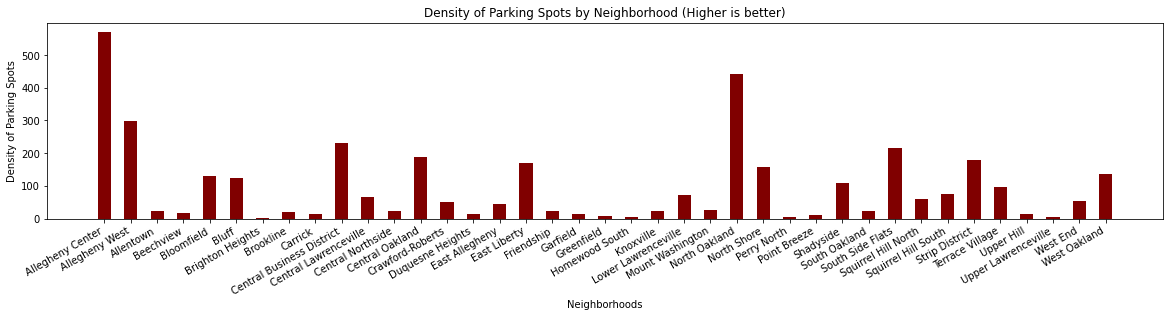

,Parking Spots,Street Miles,Density
Allegheny Center,2361,4.14,570.289855
North Oakland,6641,15.00,442.733333
Allegheny West,1448,4.87,297.330595
Central Business District,7172,30.84,232.555123
South Side Flats,5570,25.94,214.726291
Central Oakland,1776,9.50,186.947368
Strip District,3114,17.34,179.584775
East Liberty,3583,21.13,169.569333
North Shore,2151,13.60,158.161765
West Oakland,888,6.49,136.825886


In [26]:
import matplotlib.pyplot as plt
densities=[]
count=0
for numMeters in frame['Parking Spots']:        #calculates density in Parking Meters per mile of street
    numMiles=frame['Street Miles'][count]
    densities.append(numMeters/numMiles)
    count+=1
frame['Density']=densities

hoods = sorted(meters.keys())
nums = frame['Density']
fig = plt.figure(figsize = (20, 4))
plt.bar(hoods, nums, color ='maroon', width = 0.5)
fig.autofmt_xdate()
plt.xlabel("Neighborhoods")
plt.ylabel("Density of Parking Spots")
plt.title("Density of Parking Spots by Neighborhood (Higher is better)")
plt.show()
frame=frame.sort_values('Density', ascending=False)
frame.head(10)

For my metric, the best was Allegheny Center. Every one of these top 10 have very good densities though.

## **Metric 2: METRIC**
### Brandon

For my Dataset I looked at the total transactions from the park-mobile app and parking meters

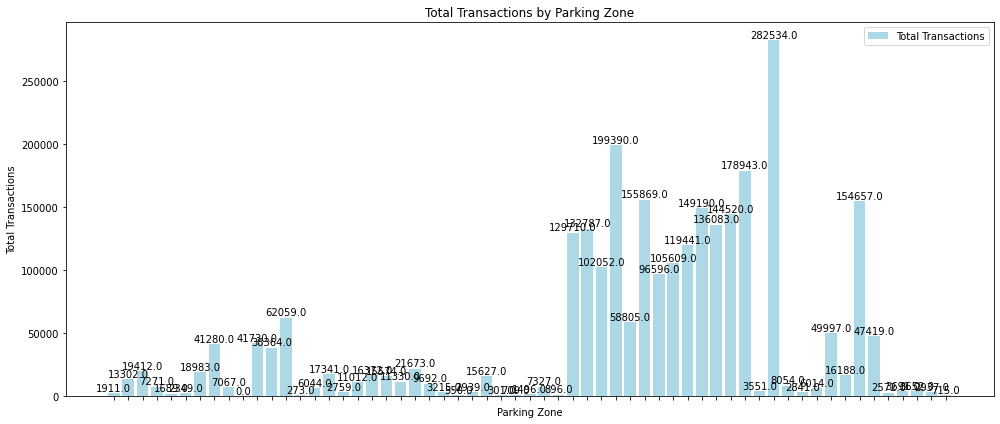

All Zones and Corresponding Total Transactions (Organized by Total Transactions):
415 - SS & SSW: 282534
404 - Strip Disctrict: 199390
413 - Squirrel Hill: 178943
406 - Bloomfield (On-street): 155869
421 - NorthSide: 154657
410 - Oakland 4: 149190
412 - East Liberty: 144520
411 - Shadyside: 136083
402 - Downtown 2: 132787
401 - Downtown 1: 129710
409 - Oakland 3: 119441
408 - Oakland 2: 105609
403 - Uptown: 102052
407 - Oakland 1: 96596
328 - Ivy Bellefonte Lot: 62059
405 - Lawrenceville: 58805
419 - Brookline: 49997
422 - Northshore: 47419
324 - Forbes Murray Lot: 41730
322 - Forbes Shady Lot: 41280
325 - JCC/Forbes Lot: 38364
344 - 18th & Carson Lot: 21673
304 - Tamello Beatty Lot: 19412
321 - Beacon Bartlett Lot: 18983
335 - Friendship Cedarville Lot: 17341
341 - 18th & Sidney Lot: 16372
420 - Mt. Washington: 16188
357 - Shiloh Street Lot: 15627
342 - East Carson Lot: 15574
302 - Sheridan Kirkwood Lot: 13302
343 - 19th & Carson Lot: 11330
338 - 42nd & Butler Lot: 11012
345 - 20th & 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your parking data
# Replace 'your_parking_data.csv' with the actual file path
parking_data = pd.read_csv('ParkingData.csv')

# Group by parking zone and calculate total transactions
zone_stats = parking_data.groupby('zone').agg({
    'meter_transactions': 'sum',
    'mobile_transactions': 'sum'
})

# Plot the bar chart
fig, ax = plt.subplots(figsize=(14, 6))  # Adjusted figure size

# Plotting total transactions
bars = ax.bar(zone_stats.index, zone_stats['meter_transactions'] + zone_stats['mobile_transactions'], color='lightblue', label='Total Transactions')

ax.set_title('Total Transactions by Parking Zone')
ax.set_xlabel('Parking Zone')
ax.set_ylabel('Total Transactions')
ax.legend()

ax.set_xticklabels([])

# Display the value on each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 1), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Sort the DataFrame by total transactions in descending order
zone_stats['TotalTransactions'] = zone_stats['meter_transactions'] + zone_stats['mobile_transactions']
zone_stats.sort_values(by='TotalTransactions', ascending=False, inplace=True)

# Print list of zones and corresponding total transactions
print("All Zones and Corresponding Total Transactions (Organized by Total Transactions):")
for idx in zone_stats.index:
    print(f"{idx}: {zone_stats['TotalTransactions'][idx]:.0f}")


## **Metric 3: Parking Spots and Rates**
### Matt

For my dataset I looked at the Space count and rates of different neighborhoods.

In [3]:
#load data from csv
lotData = pd.read_csv("Space_count_and_rate.csv",index_col="_id")
meterData = pd.read_csv("Meter_data.csv",index_col="_id")

#avg spaces overall
AvgAllSpc = lotData["spaces"].mean()
#avg rate overall
AvgAllRt = lotData["rate"].mean()

print("Avgerage number of spaces (to nearest whole space): %.0f" % (AvgAllSpc))
print("Average hourly rate: $%.2f" % (AvgAllRt))

Avgerage number of spaces (to nearest whole space): 170
Average hourly rate: $1.36


The first thing I looked at was the total average rate and spaces to compare to later. For later, I needed to translate Pittsburgh Parking Authority zones into neighborhoods.

In [4]:
#ppa zones to neighborhoods
zToN = {}

for zone in lotData['zone']:
    i=1
    for meter in meterData['zone']:
        if meter == zone:
            try:
                lat=float(meterData.iat[i,3])
                lon=float(meterData.iat[i,4])
            except:
                pass
            #print(lat,lon,geo_to_neighborhood(lat,lon))
            zToN[zone] = geo_to_neighborhood(lat,lon)
        i+=1
print('done')

done


In [5]:
#find number of spaces per neighborhood and lots per neighborhood
spacesPerN = {}
lotsPerN = {}
#dict of lists for rates per neighborhood
ratesPerN = {}
#calcd with dict of lists
avgRatePerN = {}
maxPerN = {}
minPerN = {}

for hood in zToN:
    for index, row in lotData.loc[:,['zone','spaces','rate']].iterrows():
        if hood == row['zone']:
            if hood in spacesPerN.keys():
                spacesPerN[zToN[hood]]+=row['spaces']
                lotsPerN[zToN[hood]]+=1
                ratesPerN[zToN[hood]].append(row['rate'])
            else:
                spacesPerN[zToN[hood]]=row['spaces']
                lotsPerN[zToN[hood]]=1
                ratesPerN[zToN[hood]] = [row['rate']]

#calc min max and avg
for hood in ratesPerN:
    ratesPerN[hood].sort()
    minPerN[hood] = ratesPerN[hood][0]
    ratesPerN[hood].reverse()
    maxPerN[hood] = ratesPerN[hood][0]
    hoodTot=0
    for vals in ratesPerN[hood]:
        hoodTot+=vals
    avgRatePerN[hood] = vals/lotsPerN[hood]
    
print('done') 

#Creating dataframes for plotting
lotDataDict = {}
count = 5
hoods = []
for hood in spacesPerN:
    lotDataDict[hood] = [spacesPerN[hood],lotsPerN[hood],avgRatePerN[hood],minPerN[hood],maxPerN[hood]]
    hoods.append(hoods)
lotDataFrame = pd.DataFrame(lotDataDict, index=['spaces','lots','avg rate','min rate','max rate'])
lotDataFrame.head(5)

done


,Squirrel Hill South,Bluff,None,South Side Flats,Bloomfield,South Oakland,Allegheny Center,Central Business District,Shadyside,Strip District,...,North Shore,Crawford-Roberts,East Liberty,Beechview,North Oakland,Central Lawrenceville,Central Northside,East Allegheny,Brookline,Carrick
spaces,201.0,29.0,78.0,98.0,48.0,69.0,428.0,476.0,27.0,24.0,...,45.0,13.0,757.0,299.0,572.0,483.0,354.0,707.0,237.0,52.0
lots,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
avg rate,1.0,1.0,1.0,1.0,NaN,1.0,1.5,3.0,1.0,1.0,...,2.0,1.0,1.0,4.0,3.0,1.5,1.5,1.5,3.0,1.0
min rate,1.0,1.0,1.0,1.0,NaN,1.0,1.5,3.0,1.0,1.0,...,2.0,1.0,1.0,4.0,3.0,1.5,1.5,1.5,3.0,1.0
max rate,1.0,1.0,1.0,1.0,NaN,1.0,1.5,3.0,1.0,1.0,...,2.0,1.0,1.0,4.0,3.0,1.5,1.5,1.5,3.0,1.0


Next was gethering data. While processing this data I realized the zones directly correlate to neighborhoods so the data shows one lot per neighborhood so the min and max rates per neighborhood were irrelevant. Next was the graphing of data.

### Parking Spots Per Neighborhood ###

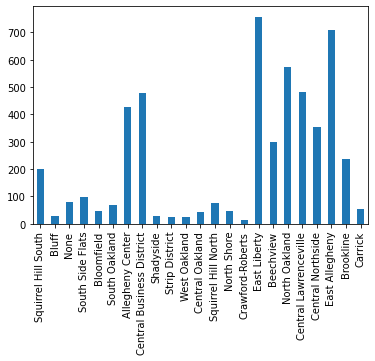

In [6]:
lotDataFrame.loc['spaces'].plot.bar()

### Rate Per Neighborhood ###

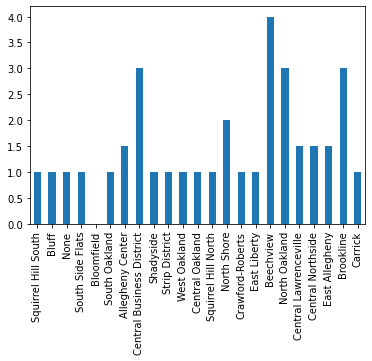

In [7]:
lotDataFrame.loc['avg rate'].plot.bar()

I then compared this data to the overall averages and graphed the results. The top graph looks at rate and the bottom looks at parking spots.

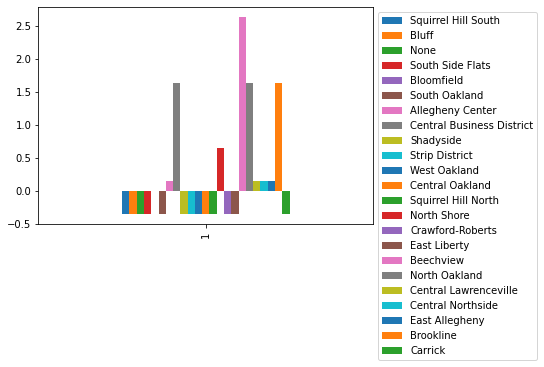

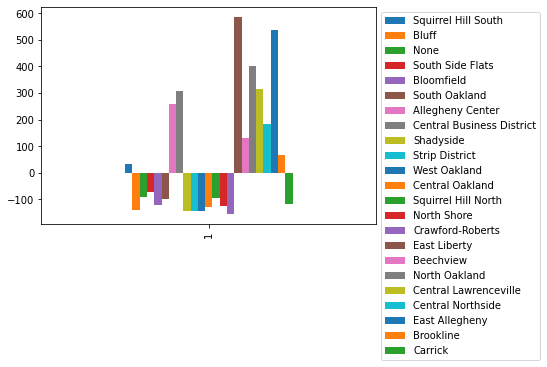

In [8]:
# graph showing distance from average of all neighborhoods
varRate = {}
varSpc = {}
for hood in spacesPerN:
    varRate[hood] = lotDataFrame.at['avg rate',hood] - AvgAllRt
    varSpc[hood] = lotDataFrame.at['spaces',hood] - AvgAllSpc

# turning the varDicts into a df
varRateDF = pd.DataFrame(varRate, index=[1])
varSpcDF = pd.DataFrame(varSpc, index=[1])
varRateDF.plot.bar().legend(bbox_to_anchor=(1.0, 1.0))
varSpcDF.plot.bar().legend(bbox_to_anchor=(1.0, 1.0))

The best neighborhood by a landslide for my metric ended up beign South Oakland. This surprised me because of the amount of trouble my friends have had parking near me, until I considered that the data did not consider permit parking and was limited to metered lots.

# **Combining the Metrics:**

The way we combined the metrics was to manually select which one scored the highest placements in all categories.

# **Conclusions:**

Quinn:

- My favorite neighborhood is good old South Oakland, but assuming you don't have a specific permit to park there, there are very few metered spots there which caused it to score low on that metric. I overall don't have much to say about this because I am still not too familiar with the many neighborhoods in Pittsburgh. I was still suprised that a neighborhood so downtown was the winner. Based on the data, though, I can trust that Strip District is the best place to park.

Matt:

- From my data the easiest neighborhood to park in with the lowest rate is South Oakland. This however only accounts for metered parking. South Oakland Parking lots have the most spaces and was tied for the lowest rate. Combining datasets, though, Strip distric is definitely the best, with only slightly above average rates and above average number of spaces.

Brandon:

- The best neighborhood to park in is South Side, South side has the most total transactions by a large margin which means there must be an abundence of parking spots for the people. Although South Side has the most tranactions, other data has pointed out that South Side has a disadvantage compared to areas like the Strip District. When combining the data from all of our data-sets, I believe that the Strip District is the best neighborhood to park.